# Bootes III Part 1

**The tasks completed in this notebook**

1. Identify BooIII spectroscopic member stars from S5 data
    - Take region near BooIII (radius 3 degrees)
    - Filter out poor measurement stars
    - RV cut from the RV histogram
    - PM box cut from the PM space
    - Crossmatch with RRL catalogue to find RRL stars
    - Plot them in 4 parameter spaces: (RA, Dec), PM, CMD, RV vs. [Fe/H]
    - Take only the stars within 5 half-light radius
    
    
2. Find kinematics and metallicity information of BooIII from the members
    - Compute systemic RV and the velocity dispersion using the stars not identified in the Gaia DR3 RRL catalogue
    - Compute mean PM, [Fe/H] and [Fe/H] dispersion using all stars


3. Use these systemic information to identify possible left out members.
    - Consider uncertainties of the data points (rather than an ordinary box cut without error bars)
   
   
The commented cells don't need to run to produce the results. But they can be uncommented to show what happens during the intermediate steps.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import table
from astropy.io import ascii

# Helper functions
from plot_functions import *
from analysis_functions_v2 import *

In [2]:
params['xtick.labelsize'] = 10
params['ytick.labelsize'] = 10
# params imported from plot_functions
plt.rcParams.update(params)

# Label shortcuts
pmra_label = r'$\mu_{\alpha}$cos($\delta$) [mas yr$^{-1}$]'
pmdec_label = r'$\mu_{\delta}$ [mas yr$^{-1}$]'

# Known physical properties for analysis
# Source: Carlin 2018, https://iopscience.iop.org/article/10.3847/1538-4357/aad8c1#apjaad8c1t3
RA_BOO3, DEC_BOO3 = 209.3, 26.8 # deg
dm_boo3 = distance_to_dm(46.5 * 1000)

# Isochrone 
dartmouth_isochrone = ascii.read('boo3_iso.iso', header_start=8)
parsec_isochrone = ascii.read('parsec_isochrone.txt', header_start=13)

# M92 ridgeline for the BHB part of the isochrone, to be paired with the dartmouth isochrone
# Note: this is gr color and g mag (not g and r mags).
gr_iso_BHB, g_iso_BHB = get_BHB_iso_color_n_mag()

# Styx stream track (Grillmair 2009)
styx_trace = ascii.read('styx.trace')

## S5 data and Gaia DR3 RR Lyrae data

In [3]:
# S5
with fits.open('s5dr32_gdr3.fits') as hdu_list:
    table_S5_full = table.Table(hdu_list[1].data)

table_S5_full['decam_g0'], table_S5_full['decam_r0'], table_S5_full['decam_i0'], table_S5_full['decam_z0'] = deredden_mag_S5(table_S5_full)

# Gaia RRL
with fits.open('gaia_rrl_dr3_all.fits') as hdu_list:
    __table_rrl1 = table.Table(hdu_list[1].data)

with fits.open('GaiaDR3_RRLs_withMu_Lite.fits') as hdu_list: # this one has the EBV_SFD
    __table_rrl2 = table.Table(hdu_list[1].data)

table_rrl = table.join(__table_rrl1, __table_rrl2['source_id', 'EBV_SFD'], keys=['source_id'])

## Member selection
1. Filter
2. RV and PM cuts (the ranges determined when looking at histograms, here we just show the ranges, no histograms)
3. Crossmatch with RRL catalogue
4. Select 5 half-light radius

In [4]:
table_S5_cut = angular_radius_cut(table_S5_full, [RA_BOO3, DEC_BOO3], 3)

sel_S5_quality = (table_S5_cut['best_sn_1700d'] > 2) & \
                 (table_S5_cut['vel_calib_std'] < 10) & \
                 (table_S5_cut['good_star_pb'] > 0.5)

table_S5_good = table_S5_cut[sel_S5_quality]

In the cell below, the two selection criteria were manually determined by examining the plots\
Here we just put down the final results

The plot shows which part of the RV distribution is selected. \
The green doesn't fill to the top because there is also a PM box cut \
done on the PM distribution (to remove visibility obvious PM outliers).


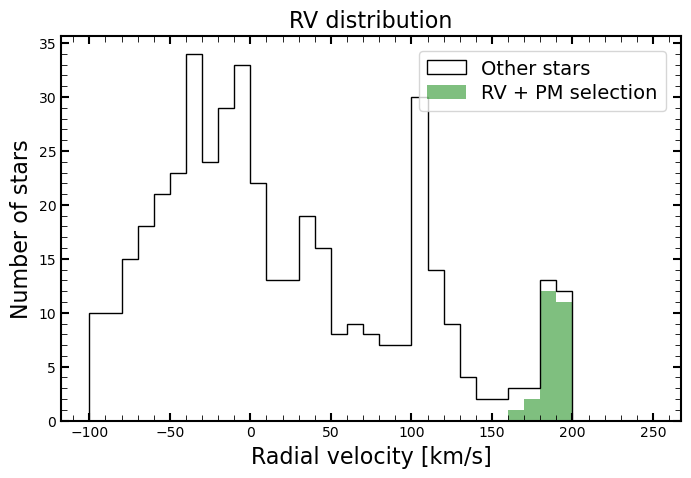

In [5]:
sel_rv_peak = (150 < table_S5_good['vel_calib']) & (table_S5_good['vel_calib'] < 240)
sel_pm = (-2 < table_S5_good[sel_rv_peak]['pmra']) & (table_S5_good[sel_rv_peak]['pmra'] < -0.5) & \
         (-1.4 < table_S5_good[sel_rv_peak]['pmdec']) & (table_S5_good[sel_rv_peak]['pmdec'] < -0.4) #alt: -1.6 to -0.2

boo3_S5_sample = table_S5_good[sel_rv_peak][sel_pm]

plt.figure(figsize=(8, 5))
plt.hist(table_S5_good['vel_calib'], bins=35, range=[-100, 250], histtype='step', ec='k', label='Other stars')
plt.hist(boo3_S5_sample['vel_calib'], bins=35, range=[-100, 250], fc='g', alpha=0.5, label='RV + PM selection')
plot_labels('Radial velocity [km/s]', 'Number of stars', 'RV distribution')
plt.legend(loc="upper right") #, bbox_to_anchor=(1.6, 0.5), prop={'size': 14})
plt.show()

Find RRL stars.

In the cell below, `rrl_matched_to_base` and `boo3_sample_rrl` contain the same stars but different table info. We need the `rrl_matched_to_base` (from `table_rrl`) to derive their distance moduli. But before that we need to get mean [Fe/H], so we do that immediately after identifying the RRLs.

After this we write the data out to `boo3_main_rrl.dat`, which includes the `dm` column that is computed after the MCMC results. These cells are commented out because we will just load our finished product.

In [6]:
rrl_matched_to_base, sep2d = crossmatch(boo3_S5_sample, table_rrl, get_sep2d=True)
boo3_main_rrl = boo3_S5_sample[sep2d < 1*units.arcsec]

boo3_main_members = table.setdiff(boo3_S5_sample, boo3_main_rrl, keys=['source_id'])

len(boo3_S5_sample), len(boo3_main_rrl), len(boo3_main_members)

(26, 3, 23)

Now we take only the stars within 5 half-light radii.
Here we just use the RA values to select those indices because the plot shows it clearly.

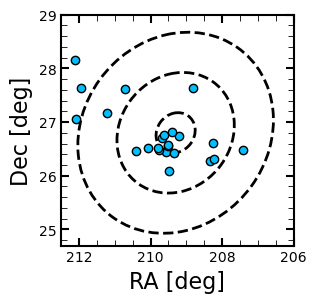

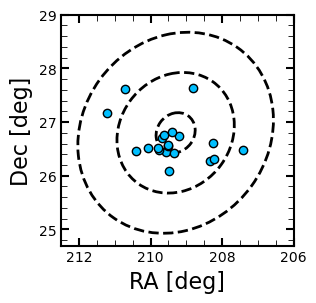

In [7]:
fig, ax = plt.subplots(figsize=(3, 3))
plot_rh(ax)
ax.plot(boo3_main_members['ra'], boo3_main_members['dec'], 'o', c='deepskyblue', mec='k')
ax.set_xlabel('RA [deg]')
ax.set_ylabel('Dec [deg]')
ax.set_xlim(206, 212.5)
ax.set_ylim(24.7, 29)
ax.invert_xaxis()
plt.show()

index_to_keep = np.invert(boo3_main_members['ra'] > 211.5)

boo3_main_members = boo3_main_members[index_to_keep]

fig, ax = plt.subplots(figsize=(3, 3))
plot_rh(ax)
ax.plot(boo3_main_members['ra'], boo3_main_members['dec'], 'o', c='deepskyblue', mec='k')
ax.set_xlabel('RA [deg]')
ax.set_ylabel('Dec [deg]')
ax.set_xlim(206, 212.5)
ax.set_ylim(24.7, 29)
ax.invert_xaxis()
plt.show()

Mean RV: 191.31154498616135 -0.7966016243160254 0.6842557159389742
RV dispersion: 1.8706076475778803 -0.7352913222125208 0.9214931883686477
95% dispersion: 3.517737632506506


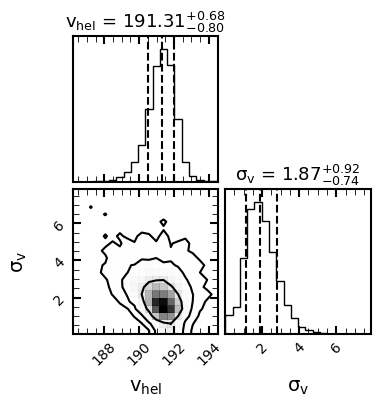

100%|██████████| 1500/1500 [00:01<00:00, 968.94it/s]


PMRA -- -1.1570924232454463 0.018143549492216193 0.017088639078883583
PMDEC-- -0.8804461553103886 0.01332692332312524 0.013233907156858016


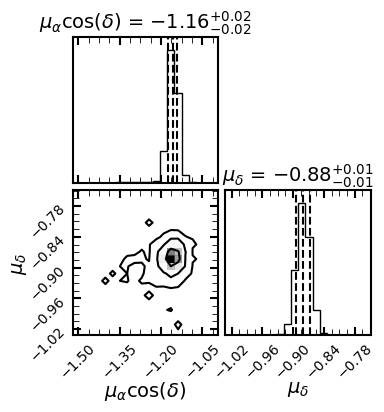

Mean [Fe/H]: -2.3083508861540065 -0.10438928323149188 0.10292915176476969
[Fe/H] dispersion: 0.40506396604907474 -0.0698999845137237 0.08579431457895431
95% dispersion: 0.5615206146093893


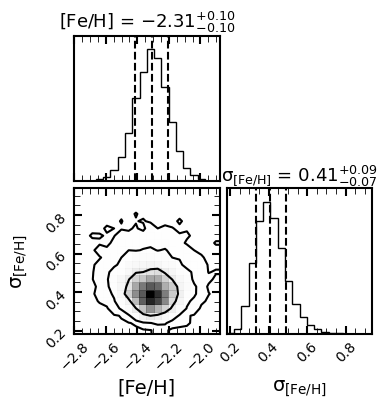

In [8]:
import vdisp
import corner
import mcmc_wrapper

# VELOCITY
samples = vdisp.mcmc(boo3_main_members['vel_calib'], boo3_main_members['vel_calib_std'], nsteps=1000)
ascii.write(samples, 'boo3_velocity_fit_sample.dat', overwrite=True)

mu = samples[:,0]
sigma = 10**samples[:,1]
samples = np.column_stack((mu, sigma))

print('Mean RV:', np.median(mu), np.percentile(mu, 16) - np.median(mu), np.percentile(mu, 84) - np.median(mu))
print('RV dispersion:', np.median(sigma), np.percentile(sigma, 16) - np.median(sigma), np.percentile(sigma, 84) - np.median(sigma)) 
print('95% dispersion:', np.percentile(sigma, 95)) 

figure = corner.corner(samples,
                       labels=["$\mathrm{v_{hel}}$", "$\mathrm{\sigma_{v}}$"],
                       quantiles=[0.16, 0.50, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 13},
                       plot_datapoints = False,
                       levels = (0.68, 0.95, 0.997),
                       label_kwargs = dict(fontsize=14),
                       ls='--', lw=1.5, c='gray', alpha=0)
figure.set_size_inches(4, 4)
plt.savefig('rv_fit.png', dpi=300)
plt.show()

# PROPER MOTION
all_pmra = np.concatenate((boo3_main_members['pmra'], boo3_main_rrl['pmra']))
all_pmra_err = np.concatenate((boo3_main_members['pmra_error'], boo3_main_rrl['pmra_error']))
all_pmdec = np.concatenate((boo3_main_members['pmdec'], boo3_main_rrl['pmdec']))
all_pmdec_err = np.concatenate((boo3_main_members['pmdec_error'], boo3_main_rrl['pmdec_error']))
all_pm_corr = np.concatenate((boo3_main_members['pmra_pmdec_corr'], boo3_main_rrl['pmra_pmdec_corr']))

data_in = [all_pmra, all_pmdec, all_pmra_err, all_pmdec_err, all_pm_corr]

data_out = mcmc_wrapper.mcmc_pm(data_in, nsteps=1000)

_, _, samples = mcmc_wrapper.plot_pm(data_out)
ascii.write(samples, 'boo3_pm_fit_sample.dat', overwrite=True)

# METALLICITY
all_feh = np.concatenate((boo3_main_members['feh50'], boo3_main_rrl['feh50']))
all_feh_err = np.concatenate((boo3_main_members['feh_calib_std'], boo3_main_rrl['feh_calib_std']))

samples = vdisp.mcmc(all_feh, all_feh_err, nsteps=1000)
ascii.write(samples, 'boo3_feh_fit_sample.dat', overwrite=True)

mu = samples[:,0]
sigma = 10**samples[:,1]
samples = np.column_stack((mu, sigma))

# Median, and percentiles
print('Mean [Fe/H]:', np.median(mu), np.percentile(mu, 16) - np.median(mu), np.percentile(mu, 84) - np.median(mu))
print('[Fe/H] dispersion:', np.median(sigma), np.percentile(sigma, 16) - np.median(sigma), np.percentile(sigma, 84) - np.median(sigma)) 
print('95% dispersion:', np.percentile(sigma, 95)) 

figure = corner.corner(samples,
                       labels=["[Fe/H]", "$\mathrm{\sigma_{[Fe/H]}}$"],
                       quantiles=[0.16, 0.50, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 13},
                       plot_datapoints = False,
                       levels = (0.68, 0.95, 0.997),
                       label_kwargs = dict(fontsize=14),
                       ls='--', lw=1.5, c='gray', alpha=0)
figure.set_size_inches(4, 4)
plt.savefig('feh_fit.png', dpi=300)
plt.show()

In [9]:
rv_mean = 191.31154498616135
rv_mean_err = (0.7966016243160254 + 0.6842557159389742) / 2
rv_disp = 1.8706076475778803
rv_disp_err = (0.7352913222125208 + 0.9214931883686477) / 2

feh_mean = -2.3083508861540065
feh_mean_err = (0.10292915176476969 + 0.10438928323149188) / 2
feh_disp = 0.40506396604907474
feh_disp_err = (0.08579431457895431 + 0.0698999845137237) / 2

pmra = -1.1570924232454463
pmra_err = (0.018143549492216193 + 0.017088639078883583) / 2
pmdec = -0.8804461553103886 
pmdec_err = (0.01332692332312524 + 0.013233907156858016) / 2

In [10]:
add_dm_to_RRLs(rrl_matched_to_base, feh_mean)
boo3_main_rrl = table.hstack([boo3_main_rrl, rrl_matched_to_base['dm']])

In [11]:
ascii.write(boo3_main_members, 'boo3_main_members.dat', overwrite=True)
ascii.write(boo3_main_rrl, 'boo3_main_rrl.dat', overwrite=True)

### Key Figure 1: main spectroscopic members, and overplotting members from Carlin 2018

In [13]:
boo3_main_members = ascii.read('boo3_main_members.dat')
boo3_main_rrl = ascii.read('boo3_main_rrl.dat')

# The rest of this cell is just processing a table
carlin18_members = ascii.read('carlin2018_members.txt', header_start=2, data_start=4, data_end=-5, delimiter='\t')
carlin18_members = carlin18_members[carlin18_members['Member?'] == 'Y']

carlin18_members.rename_column('alpha', 'ra')
carlin18_members.rename_column('delta', 'dec')
carlin18_members.rename_column('mu_alpha*', 'pmra')
carlin18_members.rename_column('mu_delta', 'pmdec')
carlin18_members.rename_column('v_helio', 'rv')

def separate_errors(table, column_name):
    """An exclusive helper function for a specific table.
    
    One-time use only.
    """
    nominals = []
    errors = []

    for rv in carlin18_members[column_name]:
        nominal, error = rv.split(' +or- ')
        nominals.append(float(nominal))
        errors.append(float(error))

    table[column_name] = nominals
    table[column_name + '_error'] = errors

separate_errors(carlin18_members, 'rv')
separate_errors(carlin18_members, 'pmra')
separate_errors(carlin18_members, 'pmdec')

fehs = []

for feh in carlin18_members['[Fe/H]^a']:
    if feh == 'cdots':
        fehs.append(np.nan)
    else:
        fehs.append(float(feh))

carlin18_members['feh'] = fehs

In [14]:
pm_cut_box = shapelyPolygon([[-2, -1.4], [-2, -0.4], [-0.5, -0.4], [-0.5, -1.4]])

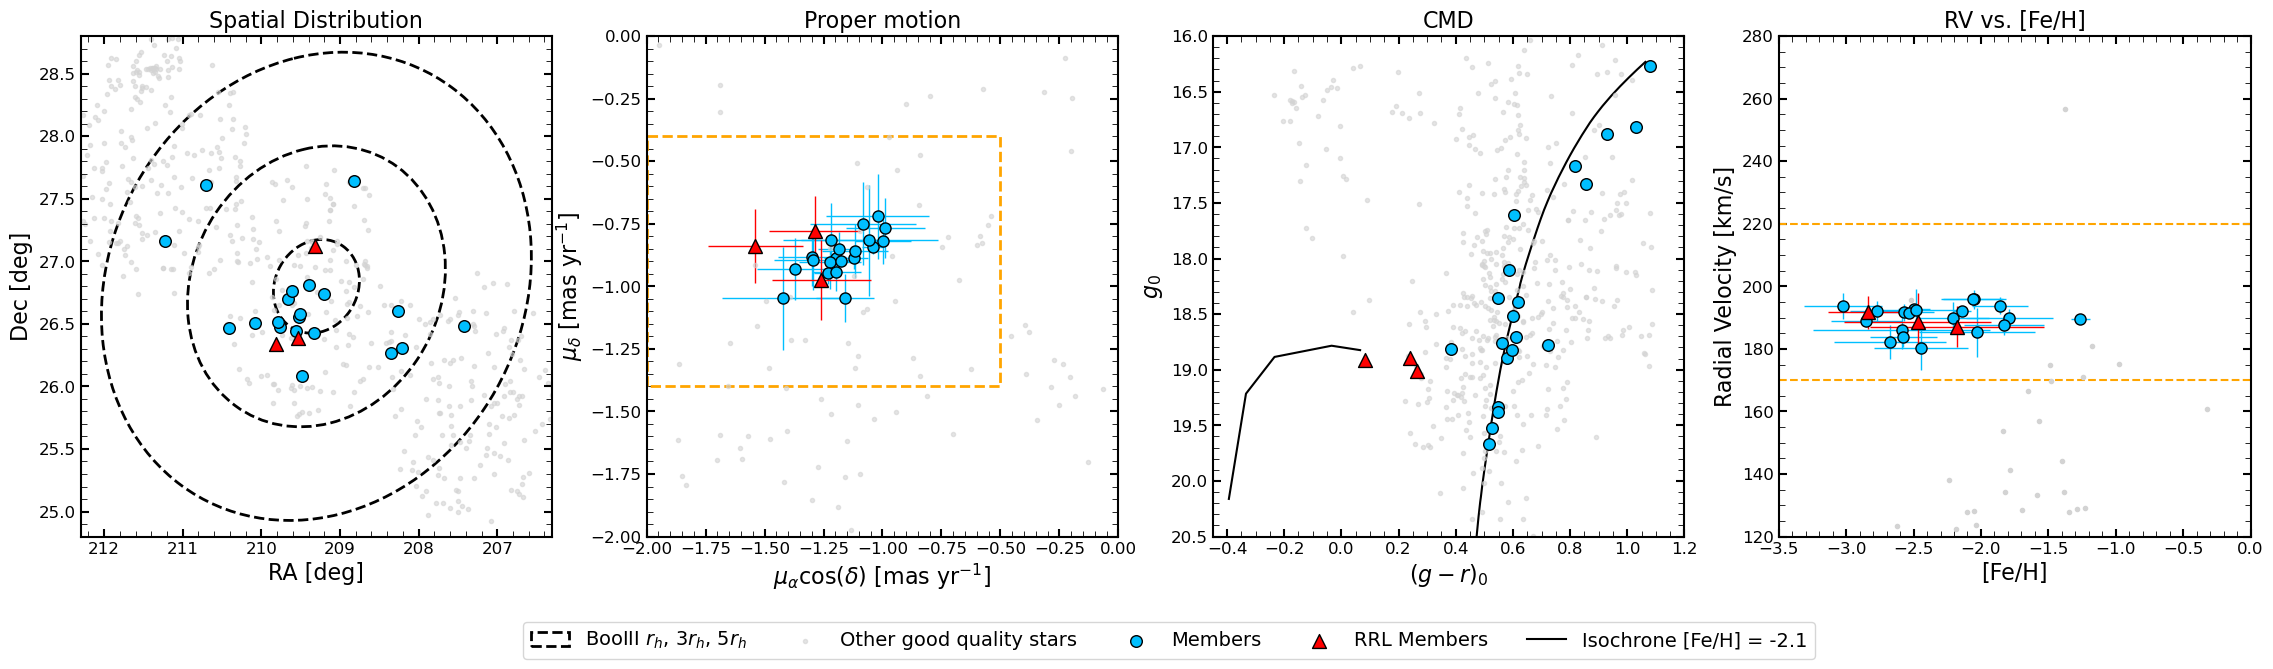

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(28, 6.5))

plot_rh(ax[0])
plot_onsky(fig, ax[0], table_S5_good, 'Other good quality stars', marker='.', c='lightgray', zorder=1, alpha=0.6)
#plot_onsky(fig, ax[0], carlin18_members, 'Carlin 2018', marker='D', s=80, c='none', ec='k', zorder=2)
plot_onsky(fig, ax[0], boo3_main_members, 'Members', marker='o', s=70, c='deepskyblue', ec='k', zorder=2)
plot_onsky(fig, ax[0], boo3_main_rrl, 'RRL Members', marker='^', s=100, c='red', ec='k', zorder=2)
ax_labels(ax[0], 'RA [deg]', 'Dec [deg]', 'Spatial Distribution')
ax[0].set_xlim(RA_BOO3-3, RA_BOO3+3)
ax[0].set_ylim(DEC_BOO3-2, DEC_BOO3+2)
ax[0].invert_xaxis()

plot_pm_ax(ax[1], table_S5_good, '', fmt='.', c='lightgray', capsize=0, lw=0, alpha=0.6)
#plot_pm_ax(ax[1], carlin18_members, '', fmt='D', ms=8, c='none', mec='k', capsize=0, ecolor='gray', lw=1)
plot_pm_ax(ax[1], boo3_main_members, '', fmt='o', ms=8, c='deepskyblue', mec='k', capsize=0, lw=1)
plot_pm_ax(ax[1], boo3_main_rrl, '', fmt='^', ms=10, c='red', mec='k', capsize=0, lw=1)
ax[1].plot(*pm_cut_box.exterior.xy, lw=2, ls='--', c='orange')
ax_labels(ax[1], pmra_label, pmdec_label, 'Proper motion')
ax[1].set_xlim(-2, 0)
ax[1].set_ylim(-2, 0)

plot_RGB_isochrone(ax[2], dartmouth_isochrone['DECam_g'], dartmouth_isochrone['DECam_r'], dm_boo3, 'Isochrone [Fe/H] = -2.1', c='k', zorder=1)
plot_BHB_isochrone(ax[2], dm_boo3, c='k')
plot_cmd(fig, ax[2], table_S5_good['decam_g0'], table_S5_good['decam_r0'], '', marker='.', c='lightgray', alpha=0.6)
#plot_cmd(fig, ax[2], carlin18_members['g'], carlin18_members['r'], '', marker='D', s=70, c='none', ec='k', zorder=2)
plot_cmd(fig, ax[2], boo3_main_members['decam_g0'], boo3_main_members['decam_r0'], '', marker='o', s=70, c='deepskyblue', ec='k', zorder=2)
plot_cmd(fig, ax[2], boo3_main_rrl['decam_g0'], boo3_main_rrl['decam_r0'], '', marker='^', s=100, c='red', ec='k', zorder=2)
ax_labels(ax[2], r'$(g-r)_0$', r'$g_0$', 'CMD')
ax[2].set_xlim(-0.45, 1.2)
ax[2].set_ylim(16, 20.5)
ax[2].invert_yaxis()

plot_rv_metallicity_ax(ax[3], table_S5_good, '', fmt='.', c='lightgray', lw=0)
#ax[3].errorbar(carlin18_members['feh'], carlin18_members['rv'], yerr=carlin18_members['rv_error'], fmt='D', ms=8, c='none', mec='k', ecolor='k', lw=1)
plot_rv_metallicity_ax(ax[3], boo3_main_members, '', fmt='o', ms=8, c='deepskyblue', mec='k', lw=1)
plot_rv_metallicity_ax(ax[3], boo3_main_rrl, '', fmt='^', ms=10, c='red', mec='k', lw=1)
ax[3].axhline(220, ls='--', c='orange') # 240
ax[3].axhline(170, ls='--', c='orange') # 150
ax_labels(ax[3], '[Fe/H]', 'Radial Velocity [km/s]', 'RV vs. [Fe/H]')
ax[3].set_ylim(120, 280)
ax[3].set_xlim(-3.5, 0)

lgd = fig.legend(loc="center right", bbox_to_anchor=(0.75, -0.05), ncol=7, prop={'size': 14})

#fig.savefig('main_members.png', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()

In [8]:
len(boo3_main_members), len(boo3_main_rrl)

(20, 3)